## 摘要

- 30分後の為替の変動を予測してみる

### データセット

- [GAIN Capital](http://ratedata.gaincapital.com/)
- 通貨ペア: USD/JPY
- 期間: 2018-03-04 〜 2018-04-19
- 間隔: 1分足

### 前提条件

- 0.3銭(0.0015%)の手数料を取られる

### 売買の方針

- 30分後の為替の変動を予測し，何もしない, 買い， 売りを決定する．
- 30秒単位で売り買いの判断を行う．
- 3銭(0.015%)以上変動しそうなら売り買いする．
- ある程度自信があるときしか買わない．

| 行動        | 値 | 説明                                      |
| ------------ | --- | ------------------------------------------- |
| 買い        | 1  |  現在の買値(Ask) < 将来の売値(Bid) |
| 空売り      | 2 |  現在の売値(Bid) > 将来の買値(Ask) |
| 何もしない | 0  |  それ以外 |    

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

ACTION_DO_NOTHING = 0
ACTION_LONG = 1 # 買い
ACTION_SHORT = 2 # 空売り
ACTION_NAMES = [u"do nothing", u"long", u"short"]

In [2]:
df = pd.read_csv("../input/exchange.csv", parse_dates=["rate_date_time"])
df = df.sort_values(by="rate_date_time").reset_index(drop=True)

In [3]:
df.head()

,rate_date_time,rate_bid_open,rate_bid_high,rate_bid_low,rate_bid_close,rate_ask_open,rate_ask_high,rate_ask_low,rate_ask_close
0,2015-01-04 17:00:00,120.491,120.555,120.483,120.506,120.527,120.625,120.527,120.568
1,2015-01-04 17:01:00,120.507,120.569,120.507,120.544,120.568,120.597,120.566,120.588
2,2015-01-04 17:02:00,120.542,120.592,120.542,120.568,120.588,120.616,120.588,120.601
3,2015-01-04 17:03:00,120.566,120.596,120.543,120.575,120.601,120.656,120.575,120.645
4,2015-01-04 17:04:00,120.576,120.587,120.502,120.585,120.646,120.646,120.520,120.608


In [4]:
df.describe()

,rate_bid_open,rate_bid_high,rate_bid_low,rate_bid_close,rate_ask_open,rate_ask_high,rate_ask_low,rate_ask_close
count,1.227489e+06,1.227489e+06,1.227489e+06,1.227489e+06,1.227489e+06,1.227489e+06,1.227489e+06,1.227489e+06
mean,1.134083e+02,1.134182e+02,1.133982e+02,1.134082e+02,1.134139e+02,1.134239e+02,1.134040e+02,1.134140e+02
std,6.324863e+00,6.324490e+00,6.325300e+00,6.324886e+00,6.324192e+00,6.323766e+00,6.324586e+00,6.324175e+00
min,9.910100e+01,9.960400e+01,9.897900e+01,9.917700e+01,9.924200e+01,9.961100e+01,9.904200e+01,9.924000e+01
25%,1.092370e+02,1.092460e+02,1.092270e+02,1.092370e+02,1.092430e+02,1.092520e+02,1.092330e+02,1.092430e+02
50%,1.128350e+02,1.128440e+02,1.128250e+02,1.128350e+02,1.128400e+02,1.128500e+02,1.128310e+02,1.128400e+02
75%,1.192640e+02,1.192740e+02,1.192540e+02,1.192640e+02,1.192680e+02,1.192780e+02,1.192580e+02,1.192680e+02
max,1.258170e+02,1.258540e+02,1.258020e+02,1.258150e+02,1.258210e+02,1.258590e+02,1.258050e+02,1.258200e+02


#### 正解データの作成

In [5]:
T = 30 # 30分後
# T = 15 # 15分後
margin = 0.03 # 3銭の変動
df["rate_bid"] = (df["rate_bid_open"] + df["rate_bid_close"]) / 2.0
df["rate_ask"] = (df["rate_ask_open"] + df["rate_ask_close"]) / 2.0
df["target_rate_bid"] = df["rate_bid"].shift(-T)
df["target_rate_ask"] = df["rate_ask"].shift(-T)
df["target_rate_date_time"] = df["rate_date_time"].shift(-T)
df["target"] = ACTION_DO_NOTHING # 何もしない
df.loc[(df["target_rate_bid"] > df["rate_ask"] + margin), "target"] = ACTION_LONG # 買いのタイミング
df.loc[(df["target_rate_ask"] + margin < df["rate_bid"]), "target"] = ACTION_SHORT # 売りのタイミング

#### 特徴抽出

In [6]:

# 時間関連
df["dow"] = df["rate_date_time"].dt.dayofweek
df["year"] = df["rate_date_time"].dt.year
df["quarter"] = df["rate_date_time"].dt.quarter
df["month"] = df["rate_date_time"].dt.month
df["weekofyear"] = df["rate_date_time"].dt.weekofyear
df["dayofyear"] = df["rate_date_time"].dt.dayofyear
df["day"] = df["rate_date_time"].dt.day
df["hour"] = df["rate_date_time"].dt.hour
df["minute"] = df["rate_date_time"].dt.minute
df["is_month_start"] = df["rate_date_time"].dt.is_month_start
df["is_month_end"] = df["rate_date_time"].dt.is_month_end
df["is_quarter_start"] = df["rate_date_time"].dt.is_quarter_start
df["is_quarter_end"] = df["rate_date_time"].dt.is_quarter_end
df["is_year_start"] = df["rate_date_time"].dt.is_year_start
df["is_year_end"] = df["rate_date_time"].dt.is_year_end
# スプレッド
df["rate_ask-rate_bid"] = df["rate_ask"] - df["rate_bid"]
# 直近との差
df["rate_bid_diff_30m"] = df["rate_bid"] - df["rate_bid"].shift(T)
df["rate_bid_diff_10m"] = df["rate_bid"] - df["rate_bid"].shift(T/3)
# 移動平均
df["rate_bid_avg_30m"] = df["rate_bid"].rolling(window=T).mean()
df["rate_bid_avg_10m"] = df["rate_bid"].rolling(window=T/3).mean()
df["rate_bid_avg_30m/rate_bid"] = df["rate_bid_avg_30m"] / df["rate_bid"]
df["rate_bid_avg_10m/rate_bid"] = df["rate_bid_avg_10m"] / df["rate_bid"]
# 分散
df["rate_bid_std_30m"] = df["rate_bid"].rolling(window=T).std()
df["rate_bid_std_10m"] = df["rate_bid"].rolling(window=T/3).std()
# ポリジャーバンド
df["rate_bid_upper_10m"] = df["rate_bid_avg_10m"] + 2.0 * df["rate_bid_std_10m"]
df["rate_bid_lower_10m"] = df["rate_bid_avg_10m"] - 2.0 * df["rate_bid_std_10m"]
df["rate_bid_upper_10m/rate_bid"] = df["rate_bid_upper_10m"] / df["rate_bid"]
df["rate_bid_lower_10m/rate_bid"] = df["rate_bid_lower_10m"] / df["rate_bid"]
# t値
df["rate_bid_t_30m"] = (df["rate_bid"] - df["rate_bid_avg_30m"]) / df["rate_bid_std_30m"]
df["rate_bid_t_10m"] = (df["rate_bid"] - df["rate_bid_avg_10m"]) / df["rate_bid_std_10m"]

# フィボナッチすごい, cf. https://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9
nums = [2, 3, 5, 8, 13, 21, 34, 55]
cols = []
for num in nums:
    interval = num
    col = "rate_bid_median_%05d" % interval
    cols.append(col)
    df[col] = df["rate_bid"].rolling(window=interval).median()
df["rate_bid_median"] = df[cols].median(axis=1)
df["rate_bid_median/rate_bid"] = df["rate_bid_median"] / df["rate_bid"] 

In [7]:
df.dropna(inplace=True)

In [8]:
df.head()

,rate_date_time,rate_bid_open,rate_bid_high,rate_bid_low,rate_bid_close,rate_ask_open,rate_ask_high,rate_ask_low,rate_ask_close,rate_bid,...,rate_bid_median_00002,rate_bid_median_00003,rate_bid_median_00005,rate_bid_median_00008,rate_bid_median_00013,rate_bid_median_00021,rate_bid_median_00034,rate_bid_median_00055,rate_bid_median,rate_bid_median/rate_bid
54,2015-01-04 17:54:00,120.574,120.576,120.572,120.573,120.592,120.594,120.582,120.587,120.5735,...,120.57750,120.5815,120.5800,120.5775,120.5755,120.571,120.52975,120.5155,120.576500,1.000025
55,2015-01-04 17:55:00,120.573,120.575,120.566,120.566,120.591,120.596,120.576,120.576,120.5695,...,120.57150,120.5735,120.5795,120.5775,120.5755,120.571,120.53800,120.5180,120.572500,1.000025
56,2015-01-04 17:56:00,120.569,120.569,120.524,120.526,120.576,120.581,120.548,120.550,120.5475,...,120.55850,120.5695,120.5735,120.5775,120.5755,120.571,120.54575,120.5180,120.570250,1.000189
57,2015-01-04 17:57:00,120.524,120.537,120.503,120.506,120.548,120.561,120.515,120.524,120.5150,...,120.53125,120.5475,120.5695,120.5765,120.5755,120.571,120.54575,120.5155,120.558500,1.000361
58,2015-01-04 17:58:00,120.508,120.528,120.507,120.513,120.524,120.540,120.524,120.537,120.5105,...,120.51275,120.5150,120.5475,120.5715,120.5755,120.571,120.54575,120.5150,120.546625,1.000300


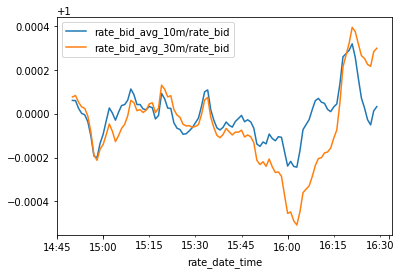

In [9]:
df[-100:].set_index("rate_date_time")[["rate_bid_avg_10m/rate_bid", "rate_bid_avg_30m/rate_bid"]].plot();

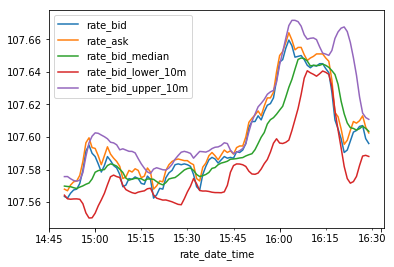

In [10]:
df[-100:].set_index("rate_date_time")[["rate_bid", "rate_ask", "rate_bid_median", "rate_bid_lower_10m", "rate_bid_upper_10m"]].plot();

In [11]:
use_columns = [
  "rate_bid_open",
  "rate_bid_high",
  "rate_bid_low",
  "rate_bid_close",
  "rate_ask_open",
  "rate_ask_high",
  "rate_ask_low",
  "rate_ask_close",
  "rate_bid",
  "rate_ask",
  "dow",
  "year",
  "quarter",
  "month",
  "weekofyear",
  "dayofyear",
  "day",
  "hour",
  "minute",
  "is_month_start",
  "is_month_end",
  "is_quarter_start",
  "is_quarter_end",
  "is_year_start",
  "is_year_end",
  "rate_ask-rate_bid",
  "rate_bid_diff_30m",
  "rate_bid_diff_10m",
  "rate_bid_avg_30m",
  "rate_bid_avg_10m",
  "rate_bid_avg_30m/rate_bid",
  "rate_bid_avg_10m/rate_bid",
  "rate_bid_std_30m",
  "rate_bid_std_10m",
  "rate_bid_upper_10m",
  "rate_bid_lower_10m",
  "rate_bid_upper_10m/rate_bid",
  "rate_bid_lower_10m/rate_bid",
  "rate_bid_t_30m",
  "rate_bid_t_10m",
  "rate_bid_median_00002",
  "rate_bid_median_00003",
  "rate_bid_median_00005",
  "rate_bid_median_00008",
  "rate_bid_median_00013",
  "rate_bid_median_00021",
  "rate_bid_median_00034",
  "rate_bid_median_00055",
  "rate_bid_median",
  "rate_bid_median/rate_bid",
]

In [12]:
num_train = int(len(df) * 0.8)
train_df = df[:num_train]
test_df = df[num_train:]

In [13]:
_start_date = train_df["rate_date_time"].min().strftime("%Y-%m-%d")
_end_date = train_df["rate_date_time"].max().strftime("%Y-%m-%d")
print "TRAIN TERM: %s - %s" % (_start_date, _end_date)

_start_date = test_df["rate_date_time"].min().strftime("%Y-%m-%d")
_end_date = test_df["rate_date_time"].max().strftime("%Y-%m-%d")
print "TRAIN TERM: %s - %s" % (_start_date, _end_date)

TRAIN TERM: 2015-01-04 - 2017-08-17
TRAIN TERM: 2017-08-17 - 2018-04-20


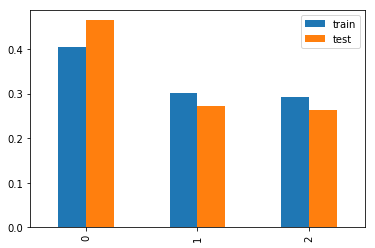

In [14]:
a = train_df["target"].value_counts(1)
b = test_df["target"].value_counts(1)
_df = pd.concat([a.to_frame(name="train"), b.to_frame(name="test")], axis=1)
_df.plot(kind="bar");

In [15]:
X_train = train_df[use_columns].values
y_train = train_df["target"].values
X_test = test_df[use_columns].values
y_test = test_df["target"].values

In [16]:
xgb_params = {
    'objective': 'multi:softprob',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.7,           
    'colsample_bytree': 0.7, 
    # 'eval_metric': 'mlogloss',
    'random_state': 777,
    'silent': 1,
    'num_class': len(set(y_train)),
}
# Simulated Hierarchical Forecast
models = []
num_model = 3
for i in range(num_model):
    train_ratio = 0.5 + 0.5 * i / num_model 
    _num_train = int(len(y_train) * train_ratio)
    dtrain = xgb.DMatrix(X_train[:_num_train], label=y_train[:_num_train], feature_names=use_columns)
    dvalid = xgb.DMatrix(X_train[_num_train:], label=y_train[_num_train:], feature_names=use_columns)
    watchlist = [(dtrain, "train"), (dvalid, "valid")]
    num_round = 3000
    model = xgb.train(
        xgb_params, dtrain, num_round, 
        evals=watchlist,
        early_stopping_rounds=100,
        verbose_eval=30,
    )
    models.append(model)

[0]	train-merror:0.54434	valid-merror:0.598485
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 100 rounds.
[30]	train-merror:0.521005	valid-merror:0.625591
[60]	train-merror:0.50508	valid-merror:0.637221
[90]	train-merror:0.492877	valid-merror:0.650177
Stopping. Best iteration:
[2]	train-merror:0.539892	valid-merror:0.590502

[0]	train-merror:0.561096	valid-merror:0.575107
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 100 rounds.
[30]	train-merror:0.540759	valid-merror:0.570079
[60]	train-merror:0.522965	valid-merror:0.57888
[90]	train-merror:0.512652	valid-merror:0.581716
Stopping. Best iteration:
[14]	train-merror:0.546872	valid-merror:0.567484

[0]	train-merror:0.56244	valid-merror:0.553141
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-mer

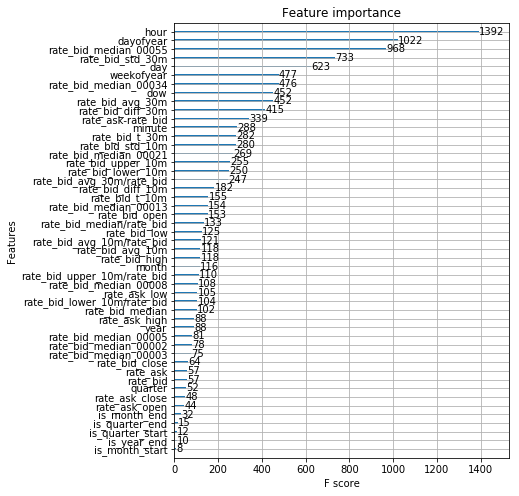

In [17]:
ax = xgb.plot_importance(model)
ax.figure.set_size_inches(6, 8);

- 判断材料としては，直近30分の売りの標準偏差(rate_bid_std_30m)と時間(hour)が多いので，何かしらの傾向が見られないか調べてみる．

#### hourの傾向

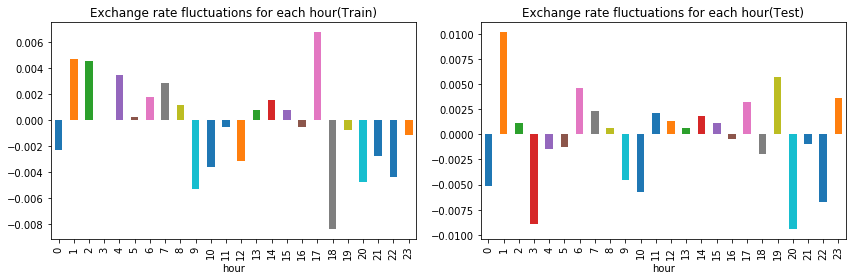

In [18]:
def _show(df, ax, title):
    df["target_rate_bid-rate_bid"] = df["target_rate_bid"] - df["rate_bid"]
    df.groupby("hour")["target_rate_bid-rate_bid"].mean().plot(kind="bar", ax=ax)
    ax.set_title(title);
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
_show(train_df, axes[0], u"Exchange rate fluctuations for each hour(Train)")
_show(test_df, axes[1], u"Exchange rate fluctuations for each hour(Test)")
fig.tight_layout();

- 訓練データとテストデータで傾向がバラバラなので，下手にこれで判断すると性能を落とすだけになりそう．
- 訓練データを細分化して，見かけ上のパラメータを除外なり，ノイズとして削いでやる必要がある．

In [19]:
dtest = xgb.DMatrix(X_test, feature_names=use_columns)
y_preda_list = []
for model in models:
    y_preda = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    y_preda_list.append(y_preda)
y_preda = np.mean(y_preda_list, axis=0)
y_pred = np.argmax(y_preda, axis=1)

In [20]:
print "Accuracy: %.4f" % accuracy_score(y_test, y_pred)
print "Recall:       %.4f" % recall_score(y_test, y_pred, average="macro")
print "Precision:  %.4f" % precision_score(y_test, y_pred, average="macro")
print "F1:             %.4f" % f1_score(y_test, y_pred, average="macro")

Accuracy: 0.4566
Recall:       0.3838
Precision:  0.3935
F1:             0.3433


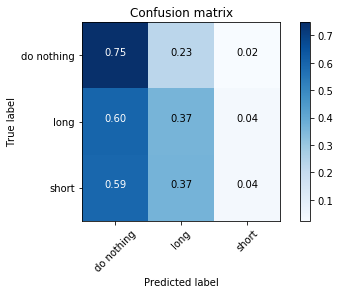

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    cf. http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=ACTION_NAMES, title='Confusion matrix')

- ほとんどの場合は何もしないを最良と判断している．
- longやshort時にdo nothingとして判断してくれるならまだしも，逆と判断してしまっているので，もっと性能改善が必要そう

## 収益計算

In [22]:
test_df["pred"] = y_pred
test_df["confidence"] = np.max(y_preda, axis=1) # 自信度

#### 自信度が正答率に影響するか？

- 何もしない以外の判断を行った場合は自信の高い場合のみ，お金を掛けたほうが勝率が高そうに考えられるので，調査してみる．

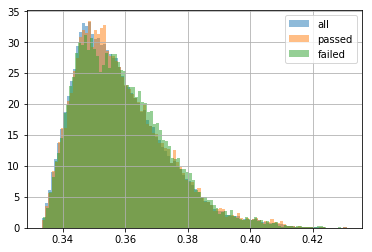

In [23]:
_df = test_df[test_df["pred"] != ACTION_DO_NOTHING] # 何もしない以外の判断を行ったデータ
ax = _df["confidence"].hist(bins=100, alpha=0.5, normed=True, label="all"); # 全部
ax = _df[_df["pred"] == _df["target"]]["confidence"].hist(bins=100, ax=ax, alpha=0.5, normed=True, label="passed"); # 正解のみ
ax = _df[_df["pred"] == 3-_df["target"]]["confidence"].hist(bins=100, ax=ax, alpha=0.5, normed=True, label="failed"); # 逆に予想
ax.legend();

- 全部の場合と正解のみ抽出した場合で，ほとんど同じ分布になっており，自信度の高さが全く意味をなしてない．
- つまり，しきい値を設定して，自信の高い場合のみ掛けても，対して期待値に違いはないことが分かる．
- 逆に予想している割合が自信度が高い方が多いような．．．
- 切ないので，一応自信のある上位9割の判断のみでなんとかしてみる．

In [24]:
def adjust_action_type(x, charge=0.003, confidence_lower=0.4):
    """
    手数料や自信度で次の行動を補正する．
    現時点では，予測に自信がある場合のみ買うよう補正しているだけ．
    他にも現在の投資額や予算などから行動を変化させるために使う．
    """
    if (x["pred"] == ACTION_DO_NOTHING) or (x["confidence"] < confidence_lower):
        return ACTION_DO_NOTHING
    if x["pred"] == ACTION_LONG: # 買って売る
        return ACTION_LONG
    if x["pred"] == ACTION_SHORT: # 売って買う
        return ACTION_SHORT

def calc_gain(x, charge=0.003):
    """
    実際に取った行動でのリターン算出
    """
    if x["action_type"] == ACTION_DO_NOTHING:
        return 0
    if x["action_type"] == ACTION_LONG: # 買って売る
        return x["target_rate_bid"] - x["rate_ask"] - 2*charge
    if x["action_type"] == ACTION_SHORT: # 売って買う
        return x["rate_bid"] - x["target_rate_ask"] - 2*charge

confidence = test_df[test_df["pred"] != ACTION_DO_NOTHING]["confidence"].values
confidence_lower = sorted(confidence)[int(len(confidence) * 0.9)]
print "Threshold of confidence: %.3f" % confidence_lower
    
test_df["action_type"] = test_df.apply(lambda x: adjust_action_type(x, confidence_lower=confidence_lower), axis=1) # 実際の行動    
test_df["gain"] = test_df.apply(calc_gain, axis=1) # リターン

Threshold of confidence: 0.378


In [25]:
print "収益の期待値(1ドルあたり): %.4f円" % test_df["gain"].mean()
print "収益の合算値: %.4f円" % test_df["gain"].sum()
print "買った回数: %d" % (test_df["action_type"] == ACTION_LONG).sum()
print "売った回数: %d" % (test_df["action_type"] == ACTION_SHORT).sum()
print "正解した回数: %d" % ((test_df["action_type"] != ACTION_DO_NOTHING) & (test_df["action_type"] == test_df["target"])).sum()
print "逆に掛けた回数: %d" % (test_df["action_type"] == 3-test_df["target"]).sum()
print "何もしなかった回数: %d" % (test_df["action_type"] == ACTION_DO_NOTHING).sum()

収益の期待値(1ドルあたり): -0.0004円
収益の合算値: -97.5585円
買った回数: 7334
売った回数: 271
正解した回数: 2596
逆に掛けた回数: 2638
何もしなかった回数: 220171


## まとめ

- XGBoostで30分後の為替変動を予測してみた．(まだまだロジックの改善が必要)
- 手数料が0.3銭/ドルとしたところ，収益の期待値は，ほぼゼロとなる．(´・ω・｀)
- 損失関数としては，逆に張ってしまった場合はかなり大きめのペナルティを加えるようにしたほうが良さそう．

## References

> [1]. [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting), kaggle, 2017.

> [2]. [GAIN Capital](http://ratedata.gaincapital.com/)

> [3]. [Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html), scikit-learn.